# BEST ESG entreprise

based on top 100 esg entreprise of 2023

scrapped from https://www.investors.com/news/esg-stocks-list-of-100-best-esg-companies/

In [3]:
import pandas as pd

In [27]:
ESG = pd.read_csv('data/ESG.csv', sep='\t').reset_index()
ESG.head(2)

,index,Rank,Company,Symbol,Industry,ESG Score,Comp Rtg,RS Rtg,EPS Rtg,SMR Rtg,3-Yr EPS Growth Rate,ROE,Last Qtr Sales % Chg,Last Qtr EPS % Chg,Div Yld
0,0,1,Worthington Industries,WOR,Metal-Processes/Fabrication,75.82,88,75,61,B,61,26,55.0,-32.0,2.4
1,1,2,J.B. Hunt Transport Services,JBHT,Transportation-Trucking,73.09,93,64,95,B,21,27,32.0,50.0,0.9


# We will use Yahoo Fiance API to get the data

In [5]:
# !pip install yfinance

In [6]:
import yfinance as yf
import pandas as pd
import datetime

In [28]:
tickers = ESG.Symbol.unique().tolist()

data = yf.download(tickers, start="2021-01-01", end=datetime.datetime.now() )
data_close = data['Close']
data_open = data['Open']

[*********************100%%**********************]  99 of 99 completed


In [29]:
data_close.to_csv("data/data_close.csv")
data_open.to_csv('data/data_open.csv')

In [30]:
# Compute absolute difference
absolute_diff = data_close - data_open
absolute_diff.to_csv('data/absolute_diff.csv')

# Compute percent difference
percent_diff = ((data_close - data_open) / data_open) * 100
percent_diff.to_csv('data/percent_diff.csv')

In [35]:
n=3
# Compute the percent difference between close and open prices over a three-day period
three_day_percent_diff = data_close.pct_change(periods=n) * 100
three_day_percent_diff = three_day_percent_diff.dropna()

# Save the computed three-day percent difference to a CSV file
three_day_percent_diff.to_csv(f'data/percent_diff_{n}days.csv')

In [33]:
absolute_diff = pd.read_csv('data/absolute_diff.csv')

n = 2
rolling_diff = percent_diff.rolling(window=n).mean()
rolling_diff = rolling_diff.dropna()


rolling_diff.to_csv(f'data/abs_rolling_diff_{n}days.csv')


In [14]:
import pandas as pd

# Load the percent_diff data
percent_diff = pd.read_csv('data/percent_diff.csv', index_col=0)

# Compute the rolling difference with a window size of n days
n = 3
rolling_diff = percent_diff.rolling(window=n).mean()  # You can use .sum() for summing instead of mean if needed

# Remove the first n - 1 rows which contain NaN values after applying rolling
# rolling_diff = rolling_diff.dropna()

# Save the rolling difference to a CSV file
rolling_diff.to_csv(f'data/percent_rolling_diff_{n}days.csv')


# scrap https://finviz.com/
In this step, we use BeautifulSoup and requests to scrape the news headline from https://finviz.com/. After you scrape the headlines and tuck them into the pd.DataFrame, you will notice that most cells in the Date column are actually empty. That is because the date format in the https://finviz.com/ causes this issue. Hence, we need to further process the data in Date column and extract the time data to fill in the Time column. Once that is done properly, we can now concatenate all the scraped headlines to produce a complete headline table.
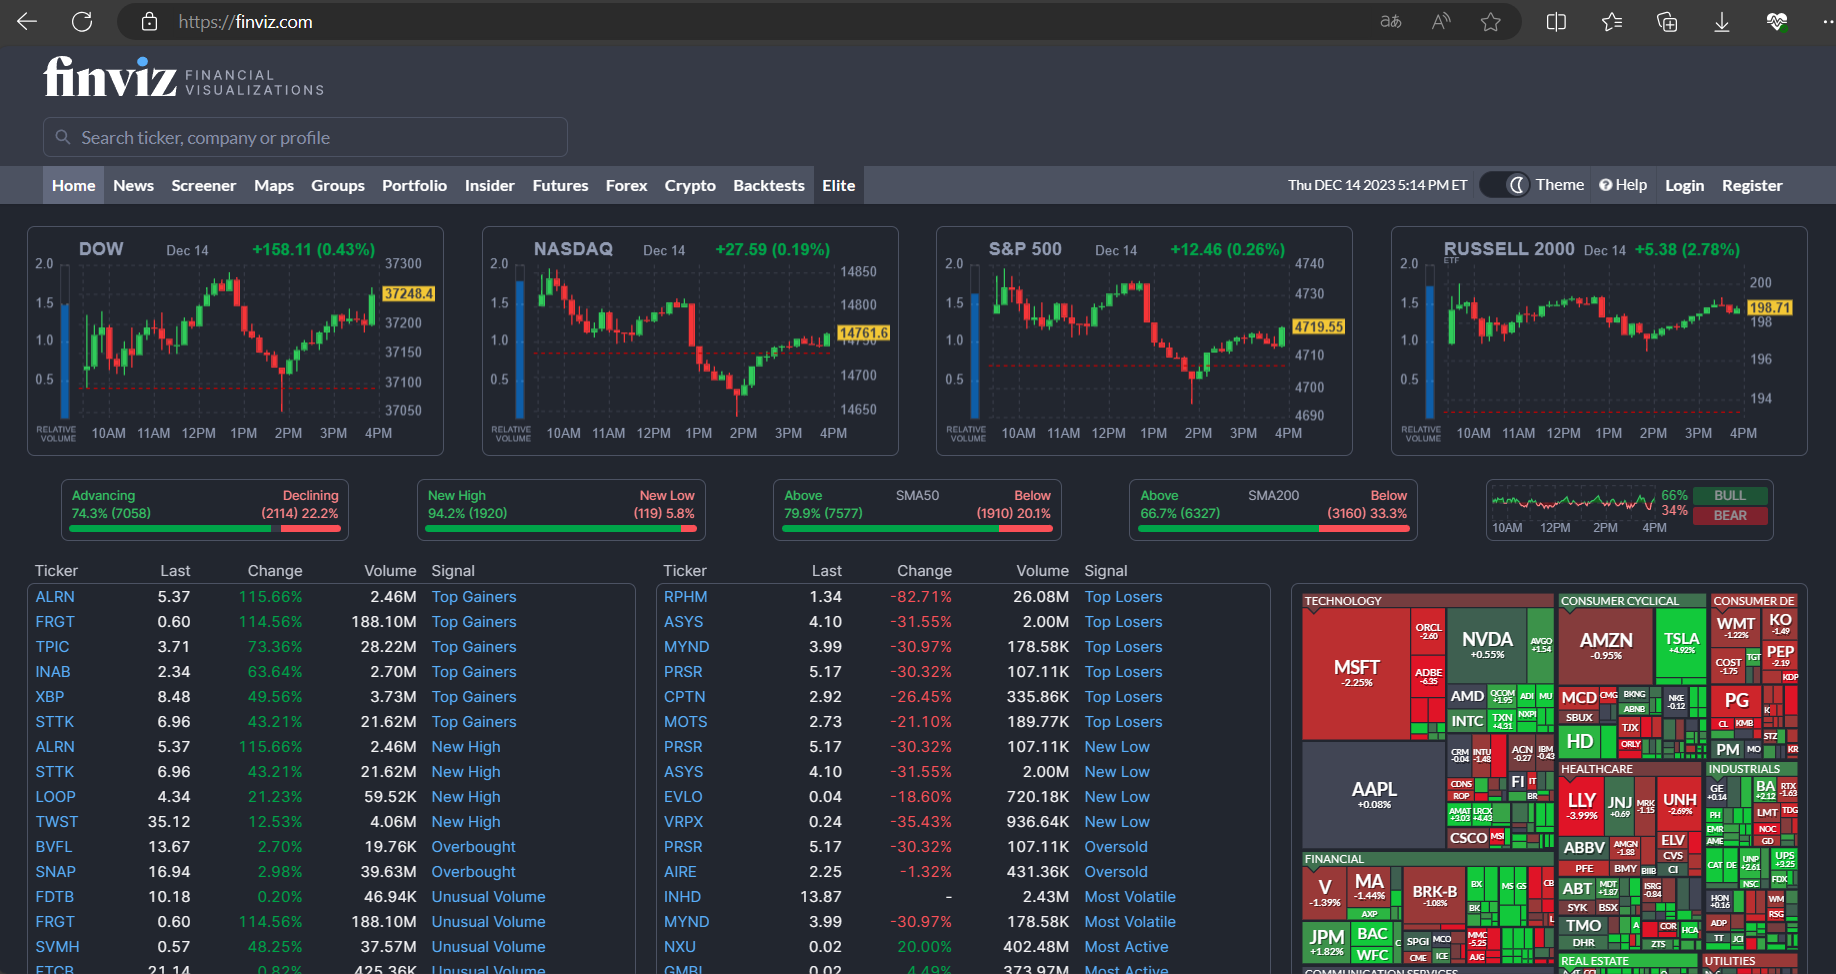

we can select the entreprise we want to look after by replacing with the ticker : "https://finviz.com/quote.ashx?t={ticker}&p=d"

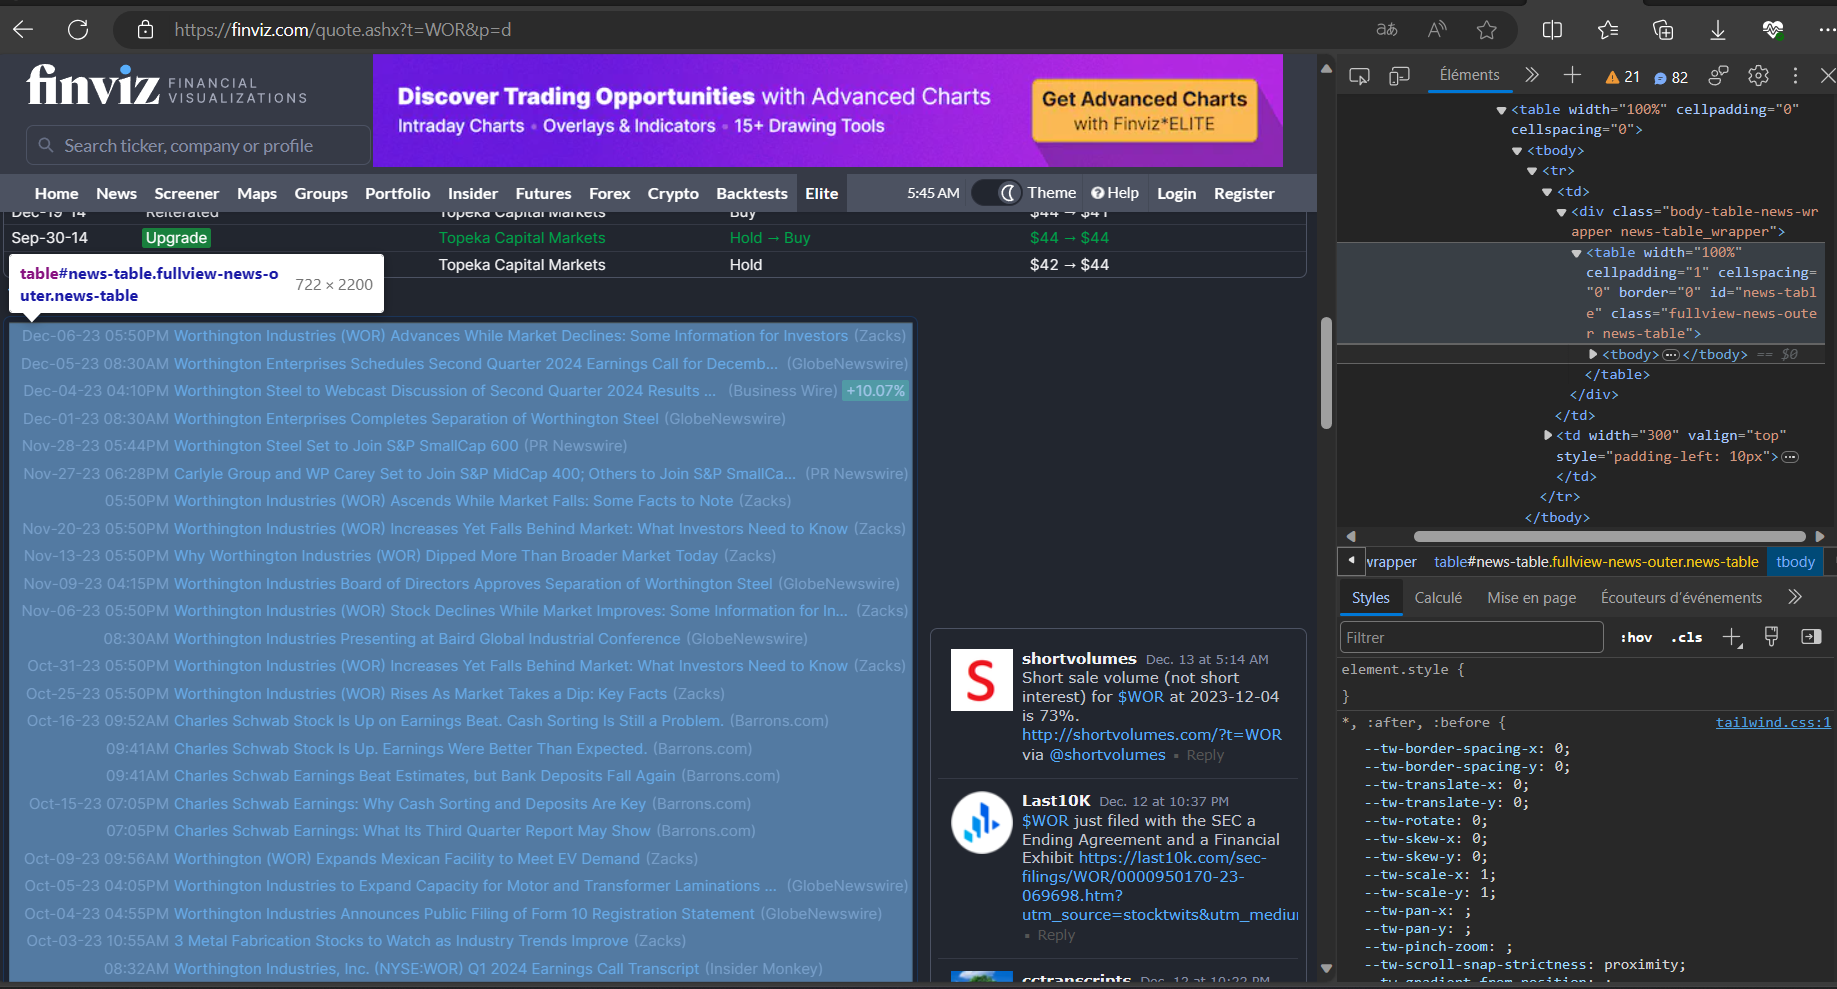

In [9]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from tqdm.notebook import tqdm 

In [10]:
tickers_list = ESG.Symbol.unique().tolist()
news = pd.DataFrame()

for ticker in tqdm(tickers_list, desc="Processing tickers"):
    url = f'https://finviz.com/quote.ashx?t={ticker}&p=d'
    ret = requests.get(
        url,
        headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'},
    )
   
    html = BeautifulSoup(ret.content, "html.parser")
    # print(html)
   
    try:
        df = pd.read_html(
            str(html),
            attrs={'class': 'fullview-news-outer news-table'}
        )[0]
    except:
        print(f"{ticker} No news found")
        continue
 
    df.columns = ['Date', 'Headline']
   
    try:
        # Process date and time columns to make sure this is filled in every headline each row
        dateNTime = df.Date.apply(lambda x: ','+x if len(x)<8 else x).str.split(r' |,', expand=True).replace("", None).ffill()
        df = pd.merge(df, dateNTime, right_index=True, left_index=True).drop('Date', axis=1).rename(columns={0:'Date', 1:'Time'})
        df.loc[:, 'Date'][df.loc[:, 'Date'] == 'Today'] = str(datetime.now().date())
        # df.Date = pd.to_datetime(df.Date)
        df.Date = pd.to_datetime(df['Date'], format='%b-%d-%y', errors='coerce')
        df.Time = pd.to_datetime(df.Time).dt.time
        df = df[df["Headline"].str.contains("Loading.") == False].loc[:, ['Date', 'Time', 'Headline']]
        df["Date"] = df["Date"].dt.date
 
        df["Ticker"] = ticker
        news = pd.concat([news, df], ignore_index=True)
    except ValueError:
        print(f"{ticker} Date format issue")
        continue


Processing tickers:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Aurélien\AppData\Local\Temp\ipykernel_4156\354991853.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(
C:\Users\Aurélien\AppData\Local\Temp\ipykernel_4156\354991853.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.Time = pd.to_datetime(df.Time).dt.time
C:\Users\Aurélien\AppData\Local\Temp\ipykernel_4156\354991853.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(
C:\Users\Aurélien\AppData\Local\Temp\ipykernel_4156\354991853.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ens

FULL No news found


C:\Users\Aurélien\AppData\Local\Temp\ipykernel_4156\354991853.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.Time = pd.to_datetime(df.Time).dt.time
C:\Users\Aurélien\AppData\Local\Temp\ipykernel_4156\354991853.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(
C:\Users\Aurélien\AppData\Local\Temp\ipykernel_4156\354991853.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.Time = pd.to_datetime(df.Time).dt.time
C:\Users\Aurélien\AppData\Local\Temp\ipykernel_4156\354991853.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be r

In [11]:
news

,Date,Time,Headline,Ticker
0,NaT,08:24:00,Worthington Enterprises May Soon Be Facing a P...,WOR
1,2023-12-15,17:50:00,Worthington Industries (WOR) Gains As Market D...,WOR
2,2023-12-06,17:50:00,Worthington Industries (WOR) Advances While Ma...,WOR
3,2023-12-05,08:30:00,Worthington Enterprises Schedules Second Quart...,WOR
4,2023-12-04,16:10:00,Worthington Steel to Webcast Discussion of Sec...,WOR
...,...,...,...,...
9889,2023-10-11,10:07:00,Post Holdings' (POST) Latest Acquisition Move ...,HRL
9890,2023-10-11,10:05:00,Hormel Foods (HRL) Battles Supply-Chain Issues...,HRL
9891,2023-10-09,09:25:00,Hormel Foods Announces Webcast of 2023 Investo...,HRL
9892,2023-10-06,09:15:00,Hormel Foods Commits to Reducing Greenhouse Ga...,HRL


In [12]:
news.to_csv('data/news_esg.csv')